In [36]:
import numpy as np
np.set_printoptions(precision=4, suppress=True) 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import re
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [1]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

ImportError: No module named 'keras'

## Load in the data and different representations of a digit

The famous dataset is available in the sklearn package

In [38]:
digits = datasets.load_digits()
print(digits['DESCR'])
print('Keys in the python dict: {}'.format(digits.keys()))

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [39]:
random_digit = np.random.choice(len(digits['images']))

### Presentation 1: plot of the pixels

Text(0.5,1,'Plot of the pixels of the digit')

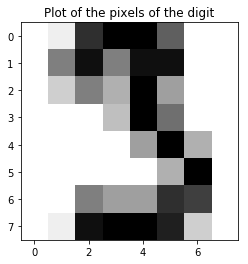

In [40]:
plt.imshow(digits['images'][random_digit], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Plot of the pixels of the digit')

### Presentation 2: matrix of grayscale values

In [41]:
print(digits['images'][random_digit])

[[  0.   1.  13.  16.  16.  10.   0.   0.]
 [  0.   8.  15.   8.  15.  15.   0.   0.]
 [  0.   3.   8.   5.  16.   6.   0.   0.]
 [  0.   0.   0.   4.  16.   9.   0.   0.]
 [  0.   0.   0.   0.   6.  16.   5.   0.]
 [  0.   0.   0.   0.   0.   5.  16.   0.]
 [  0.   0.   8.   6.   6.  13.  12.   0.]
 [  0.   1.  15.  16.  16.  14.   3.   0.]]


### Presentation 3: a vector

In [42]:
digits['data'][random_digit]

array([  0.,   1.,  13.,  16.,  16.,  10.,   0.,   0.,   0.,   8.,  15.,
         8.,  15.,  15.,   0.,   0.,   0.,   3.,   8.,   5.,  16.,   6.,
         0.,   0.,   0.,   0.,   0.,   4.,  16.,   9.,   0.,   0.,   0.,
         0.,   0.,   0.,   6.,  16.,   5.,   0.,   0.,   0.,   0.,   0.,
         0.,   5.,  16.,   0.,   0.,   0.,   8.,   6.,   6.,  13.,  12.,
         0.,   0.,   1.,  15.,  16.,  16.,  14.,   3.,   0.])

## Data scientists think data frames

- Rows presentent observations, patients, objects, times, dates or in this case a hand written digit
- Columns represent features, which can be characteristics such as age, sex, age or measurements such as in this case the intensity of a pixel

In [43]:
digits_df = pd.DataFrame(digits['data'].copy())
digits_df.columns = ['px_{}{}'.format(i,j) for i in range(8) for j in range(8)]
digits_df.index = ['digit_{}'.format(str(index).zfill(4)) for index in digits_df.index]
digits_df['digit'] = digits['target']
digits_df.sample(5)

,px_00,px_01,px_02,px_03,px_04,px_05,px_06,px_07,px_10,px_11,px_12,px_13,px_14,px_15,px_16,px_17,px_20,px_21,px_22,px_23,px_24,px_25,px_26,px_27,px_30,px_31,px_32,px_33,px_34,px_35,px_36,px_37,px_40,px_41,px_42,px_43,px_44,px_45,px_46,px_47,px_50,px_51,px_52,px_53,px_54,px_55,px_56,px_57,px_60,px_61,px_62,px_63,px_64,px_65,px_66,px_67,px_70,px_71,px_72,px_73,px_74,px_75,px_76,px_77,digit
digit_1588,0.0,2.0,16.0,16.0,16.0,12.0,0.0,0.0,0.0,1.0,9.0,5.0,12.0,16.0,2.0,0.0,0.0,0.0,0.0,6.0,15.0,14.0,2.0,0.0,0.0,0.0,1.0,16.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,12.0,16.0,5.0,0.0,0.0,0.0,1.0,16.0,16.0,13.0,1.0,0.0,0.0,3
digit_0760,0.0,0.0,0.0,8.0,15.0,9.0,1.0,0.0,0.0,0.0,11.0,14.0,12.0,15.0,8.0,0.0,0.0,0.0,15.0,5.0,6.0,14.0,2.0,0.0,0.0,0.0,14.0,14.0,15.0,1.0,0.0,0.0,0.0,1.0,13.0,16.0,6.0,0.0,0.0,0.0,0.0,6.0,16.0,9.0,13.0,0.0,0.0,0.0,0.0,2.0,13.0,15.0,16.0,4.0,0.0,0.0,0.0,0.0,1.0,9.0,15.0,2.0,0.0,0.0,8
digit_0267,0.0,0.0,0.0,0.0,14.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,11.0,0.0,0.0,0.0,0.0,0.0,10.0,16.0,9.0,0.0,0.0,0.0,0.0,0.0,13.0,16.0,7.0,0.0,0.0,0.0,0.0,12.0,16.0,16.0,4.0,0.0,0.0,0.0,1.0,13.0,12.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,10.0,0.0,0.0,1
digit_1481,0.0,0.0,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,14.0,9.0,8.0,6.0,1.0,0.0,0.0,7.0,14.0,7.0,5.0,12.0,8.0,0.0,0.0,2.0,16.0,4.0,1.0,12.0,6.0,0.0,0.0,0.0,5.0,14.0,16.0,11.0,0.0,0.0,6
digit_0221,0.0,0.0,0.0,4.0,14.0,14.0,5.0,0.0,0.0,0.0,0.0,9.0,16.0,16.0,7.0,0.0,0.0,0.0,5.0,15.0,16.0,15.0,3.0,0.0,0.0,4.0,15.0,16.0,16.0,12.0,0.0,0.0,0.0,5.0,16.0,16.0,16.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,16.0,13.0,1.0,0.0,0.0,0.0,0.0,8.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,4.0,14.0,15.0,6.0,0.0,1


### Indexing of DataFrames

- Use .loc when using labels or a boolean array with length of the index
- Use .iloc when using integers for positions or a boolean array with length of the index
- Use .ix for a mixture of both .loc and iloc



In [44]:
# Find digit 89 and 189, pixels of the first row with label based positioning
digits_df.loc[['digit_0089', 'digit_0189'],['px_00', 'px_01', 'px_02', 'px_03', 'px_04', 'px_05', 'px_06', 'px_07']]

,px_00,px_01,px_02,px_03,px_04,px_05,px_06,px_07
digit_0089,0.0,0.0,13.0,16.0,15.0,4.0,0.0,0.0
digit_0189,0.0,4.0,12.0,13.0,13.0,6.0,0.0,0.0


In [45]:
# Find digit 89, pixels of the first row with integer based positioning
digits_df.iloc[[89, 189],[0,1,2,3,4,5,6,7]]

,px_00,px_01,px_02,px_03,px_04,px_05,px_06,px_07
digit_0089,0.0,0.0,13.0,16.0,15.0,4.0,0.0,0.0
digit_0189,0.0,4.0,12.0,13.0,13.0,6.0,0.0,0.0


In [46]:
# Find digit 89, pixels of the first row by using an array of booleans
digits_df.loc[digits_df.index.isin(['digit_0089','digit_0189']),digits_df.columns.isin(['px_00', 'px_01', 'px_02', 'px_03', 'px_04', 'px_05', 'px_06', 'px_07'])]

,px_00,px_01,px_02,px_03,px_04,px_05,px_06,px_07
digit_0089,0.0,0.0,13.0,16.0,15.0,4.0,0.0,0.0
digit_0189,0.0,4.0,12.0,13.0,13.0,6.0,0.0,0.0


In [47]:
# If a single row is selected, a pandas series is returned
# Find digit 89, pixels of the first row with label based positioning
digits_df.loc['digit_0089',['px_00', 'px_01', 'px_02', 'px_03', 'px_04', 'px_05', 'px_06', 'px_07']]

px_00     0.0
px_01     0.0
px_02    13.0
px_03    16.0
px_04    15.0
px_05     4.0
px_06     0.0
px_07     0.0
Name: digit_0089, dtype: float64

## Create holdout set

20% of the data will only be used to measure the quality of our models, not to train them.

The stratified option is used, so we know there are an equal amount of each digit in the test and in the train set

In [48]:
train, holdout = train_test_split(digits_df.index, stratify=digits_df['digit'], test_size=0.2)
train = digits_df.loc[train,:].copy()
holdout = digits_df.loc[holdout,:].copy()
print('Number of digitis in the train dataset, total = {}'.format(len(train)))
print(train['digit'].value_counts())
print('\nNumber of digitis in the holdout dataset, total = {}'.format(len(holdout)))
print(holdout['digit'].value_counts())

Number of digitis in the train dataset, total = 1437
3    146
1    146
6    145
5    145
4    145
9    144
7    143
2    142
0    142
8    139
Name: digit, dtype: int64

Number of digitis in the holdout dataset, total = 360
5    37
3    37
9    36
7    36
6    36
4    36
1    36
0    36
8    35
2    35
Name: digit, dtype: int64


# Classifiy 0,1 and 2 based on a simple human decission rule

In [49]:
train_012 = train.loc[train['digit'].isin([0,1,2]),:].copy()
holdout_012 = holdout.loc[holdout['digit'].isin([0,1,2]),:].copy()

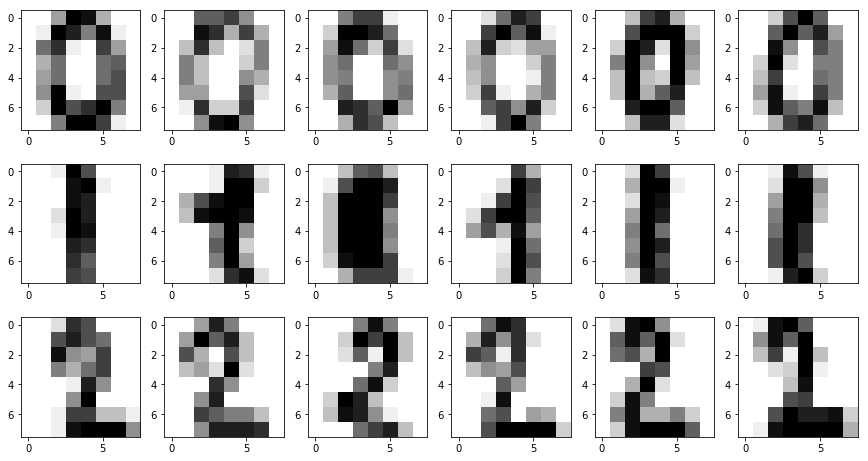

In [50]:
plt.figure(figsize=(15,8))
# Plot 5 zeros
for i in range(6):
    plt.subplot(3,6,i+1)
    random_digit = np.random.choice(train_012.loc[train_012['digit']==0,:].index)
    random_digit = int(re.sub('digit_[0]*', '', random_digit))
    plt.imshow(digits['images'][random_digit], cmap=plt.cm.gray_r, interpolation='nearest')
# Plot 5 ones
for i in range(6):
    plt.subplot(3,6,6+i+1)
    random_digit = np.random.choice(train_012.loc[train_012['digit']==1,:].index)
    random_digit = int(re.sub('digit_[0]*', '', random_digit))
    plt.imshow(digits['images'][random_digit], cmap=plt.cm.gray_r, interpolation='nearest')
# Plot 5 fives
for i in range(6):
    plt.subplot(3,6,12+i+1)
    random_digit = np.random.choice(train_012.loc[train_012['digit']==2,:].index)
    random_digit = int(re.sub('digit_[0]*', '', random_digit))
    plt.imshow(digits['images'][random_digit], cmap=plt.cm.gray_r, interpolation='nearest')

#### Based on these plots, we set manual decission rules

- If the centre pixel, px44 is white, it is a zero
- If the pixel on the bottom right corner, px66, is not white, it is a 2
- Else it is a 1


In [51]:
train_012['prediction_1'] = 1
train_012.loc[train_012['px_44'] < 2, 'prediction_1'] = 0 
train_012.loc[train_012['px_66'] > 0, 'prediction_1'] = 2

holdout_012['prediction_1'] = 1
holdout_012.loc[holdout_012['px_44'] < 2, 'prediction_1'] = 0 
holdout_012.loc[holdout_012['px_66'] > 0, 'prediction_1'] = 2

print('{:.3f}% of observations classified correclty in training dataset'.format(sum(train_012['digit'] == train_012['prediction_1'])*100/len(train_012)))
print('{:.3f}% of observations classified correclty in holdout dataset'.format(sum(holdout_012['digit'] == holdout_012['prediction_1'])*100/len(holdout_012)))

65.581% of observations classified correclty in training dataset
68.224% of observations classified correclty in holdout dataset


# Can a computer come up with this decission rule as well?

Let a computer find a single decission, that maximises the performance of the classification. We only want him to take two decissions, just as we did, so we set the max depth to 2. What decission did he take?

In [52]:
clf = DecisionTreeClassifier(max_depth=2)
features = ['px_{}{}'.format(i,j) for i in range(8) for j in range(8)]
clf = clf.fit(X=train_012[features], y=train_012['digit'])

In [53]:
train_012['prediction_2'] = clf.predict(train_012[features])
holdout_012['prediction_2'] = clf.predict(holdout_012[features])

print('{:.3f}% of observations classified correclty in training dataset'.format(sum(train_012['digit'] == train_012['prediction_2'])*100/len(train_012)))
print('{:.3f}% of observations classified correclty in holdout dataset'.format(sum(holdout_012['digit'] == holdout_012['prediction_2'])*100/len(holdout_012)))

93.023% of observations classified correclty in training dataset
91.589% of observations classified correclty in holdout dataset


In [54]:
#!conda install graphviz -y

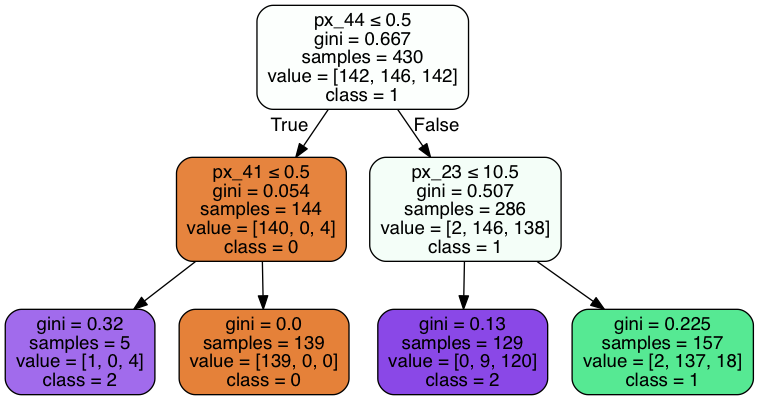

In [55]:
from IPython.display import Image  
import pydotplus 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=[str(0), str(1), str(2)],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

## A word about performance

There are many ways to look at the performance of a model: 
- Metrics such as accuracy, precission, recall (https://en.wikipedia.org/wiki/Precision_and_recall)
- Confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix)
- ROC curve (https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
- Many more: https://www.kaggle.com/wiki/Metrics

Always make sure to evaluate the model performance based on a holdout set

In [21]:
# Accuracy is very often used: 

# In multilabel classification, this function computes subset accuracy: 
#the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

print('Accuracy on training data: {:.4f}'.format(accuracy_score(y_true=train_012['digit'], y_pred=train_012['prediction_2'])))
print('Accuracy on holdout data: {:.4f}'.format(accuracy_score(y_true=holdout_012['digit'], y_pred=holdout_012['prediction_2'])))      

Accuracy on training data: 0.9302
Accuracy on holdout data: 0.9159


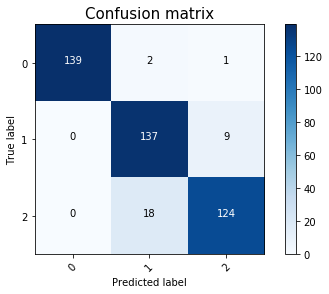

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=confusion_matrix(y_true=train_012['digit'], y_pred=train_012['prediction_2']),
                      classes=[str(0), str(1), str(2)], normalize=False)
                      

# How can a computer do better? 

A computer is good in two things:

- Doing a lot of calculations in a short time
- Remember things

### Let him grow deeper trees

This doesn't lead to a significant improvement

In [57]:
clf = DecisionTreeClassifier()
features = ['px_{}{}'.format(i,j) for i in range(8) for j in range(8)]
clf = clf.fit(X=train_012[features], y=train_012['digit'])

train_012['prediction_3'] = clf.predict(train_012[features])
holdout_012['prediction_3'] = clf.predict(holdout_012[features])

print('Accuracy on training data: {:.3f}'.format(accuracy_score(y_true=train_012['digit'], y_pred=train_012['prediction_3'])))
print('Accuracy on holdout data: {:.3f}'.format(accuracy_score(y_true=holdout_012['digit'], y_pred=holdout_012['prediction_3'])))      

Accuracy on training data: 1.000
Accuracy on holdout data: 0.935


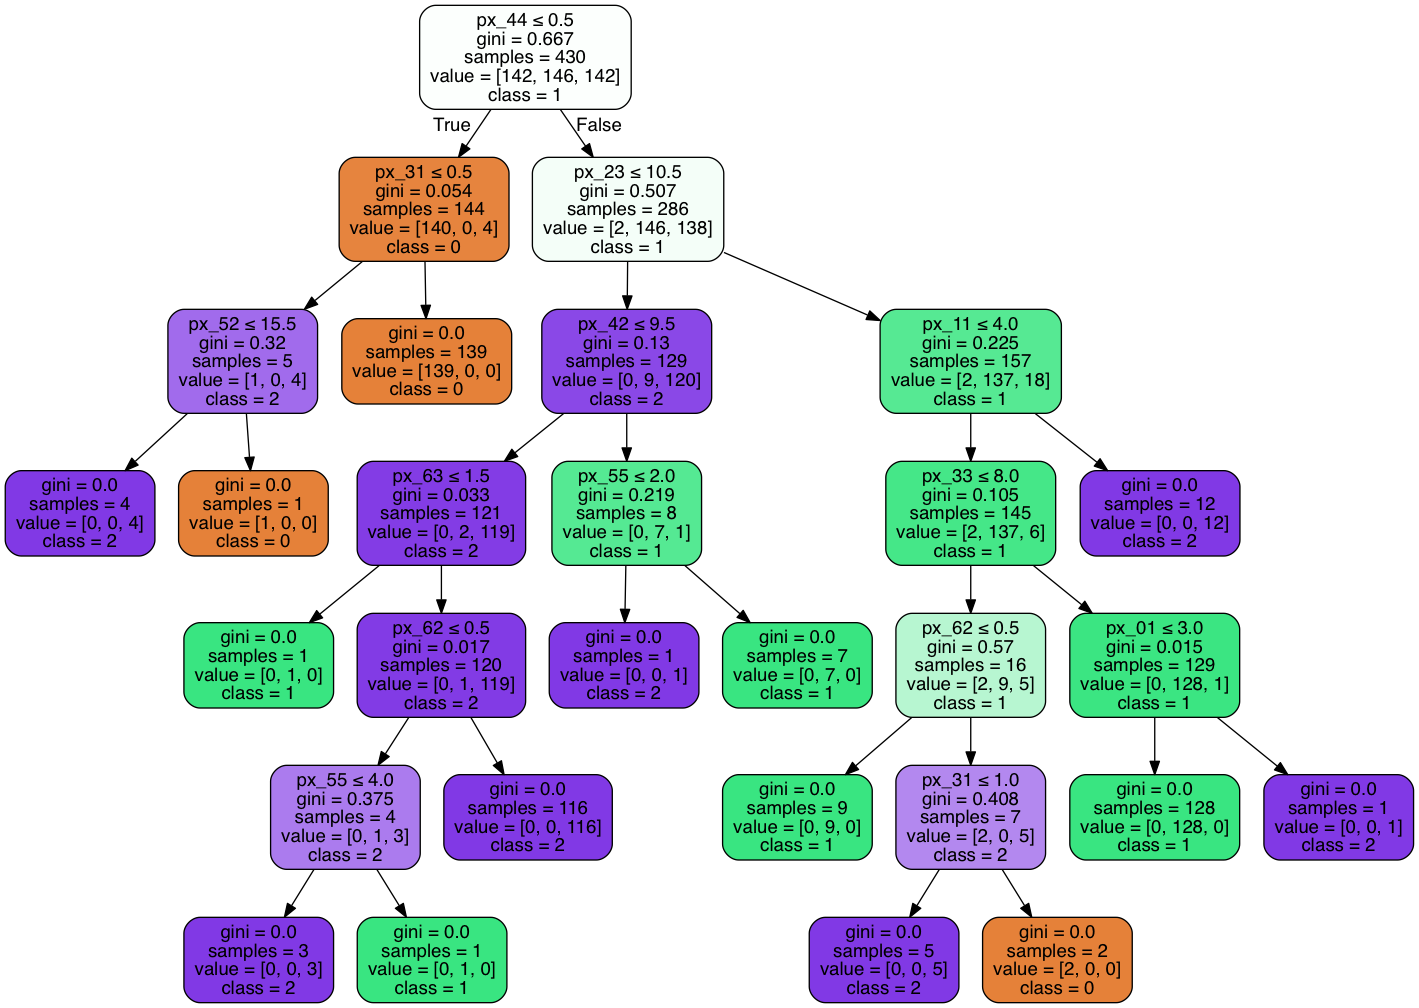

In [58]:
from IPython.display import Image  
import pydotplus 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=[str(0), str(1), str(2)],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

### Include randomness: grow many trees on subsets of the data

In [59]:
clf = RandomForestClassifier(n_estimators=50, max_features=len(features))
clf = clf.fit(X=train_012[features], y=train_012['digit'])

train_012['prediction_3'] = clf.predict(train_012[features])
holdout_012['prediction_3'] = clf.predict(holdout_012[features])

print('Accuracy on training data: {:.8f}'.format(accuracy_score(y_true=train_012['digit'], y_pred=train_012['prediction_3'])))
print('Accuracy on holdout data: {:.8f}'.format(accuracy_score(y_true=holdout_012['digit'], y_pred=holdout_012['prediction_3'])))      

Accuracy on training data: 1.00000000
Accuracy on holdout data: 0.98130841


### Include randomness: include only a subset of features at each decission

In [60]:
clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X=train_012[features], y=train_012['digit'])

train_012['prediction_3'] = clf.predict(train_012[features])
holdout_012['prediction_3'] = clf.predict(holdout_012[features])

print('Accuracy on training data: {:.3f}'.format(accuracy_score(y_true=train_012['digit'], y_pred=train_012['prediction_3'])))
print('Accuracy on holdout data: {:.3f}'.format(accuracy_score(y_true=holdout_012['digit'], y_pred=holdout_012['prediction_3'])))      

Accuracy on training data: 1.000
Accuracy on holdout data: 0.991


# Lets make it a bit more difficult, classify all the digits, not only 0,1,2

### A decission tree overfits

A decission tree has many tuning parameters, which can lead to a perfect fit on the training data. But these decission do not necessarily work on the hold out dataset.

In [61]:
clf = DecisionTreeClassifier()
clf = clf.fit(X=train[features], y=train['digit'])

train['prediction_1'] = clf.predict(train[features])
holdout['prediction_1'] = clf.predict(holdout[features])

print('The depth of the fitted tree: {}'.format(clf.tree_.max_depth))
print('Accuracy on training data: {:.3f}'.format(accuracy_score(y_true=train['digit'], y_pred=train['prediction_1'])))
print('Accuracy on holdout data: {:.3f}'.format(accuracy_score(y_true=holdout['digit'], y_pred=holdout['prediction_1'])))      

The depth of the fitted tree: 15
Accuracy on training data: 1.000
Accuracy on holdout data: 0.856


### Prevent overfitting by tuning the parameter with cross validation

The overfitting occurs because the fitted three is too deep. Use cross validation to find the optimal depth of the tree

In [62]:
clf = DecisionTreeClassifier()
grid = {'max_depth':range(1,15)}
clf_gs = GridSearchCV(estimator = clf, param_grid=grid, n_jobs=4)
clf_gs = clf_gs.fit(X=train[features], y=train['digit'])

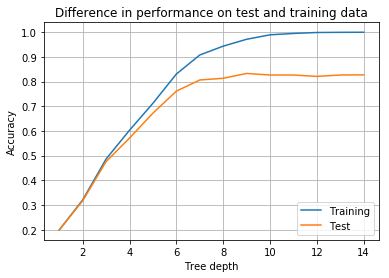

In [63]:
cv_results = pd.DataFrame(clf_gs.cv_results_)
plt.plot(cv_results['param_max_depth'],cv_results['mean_train_score'], label='Training')
plt.plot(cv_results['param_max_depth'],cv_results['mean_test_score'], label='Test')
plt.title('Difference in performance on test and training data')
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.legend(loc='lower right')
plt.grid()
#cv_results[['param_max_depth', 'mean_fit_time','mean_train_score','mean_test_score']]

In [64]:
clf = clf_gs.best_estimator_
clf = clf.fit(X=train[features], y=train['digit'])

train['prediction_2'] = clf.predict(train[features])
holdout['prediction_2'] = clf.predict(holdout[features])

print('The depth of the fitted tree: {}'.format(clf.tree_.max_depth))
print('Accuracy on training data: {:.3f}'.format(accuracy_score(y_true=train['digit'], y_pred=train['prediction_2'])))
print('Accuracy on holdout data: {:.3f}'.format(accuracy_score(y_true=holdout['digit'], y_pred=holdout['prediction_2'])))      

The depth of the fitted tree: 9
Accuracy on training data: 0.960
Accuracy on holdout data: 0.858


## Parameter tuning random forest

In [65]:
from sklearn.metrics import make_scorer

In [66]:
clf = RandomForestClassifier()
grid = {'max_depth':range(1,10), 'n_estimators':[1,2,4,8,16,32,64, 128, 264]}
clf_gs = GridSearchCV(estimator = clf, param_grid=grid, n_jobs=4, scoring=make_scorer(accuracy_score))
clf_gs = clf_gs.fit(X=train[features], y=train['digit'])
cv_results = pd.DataFrame(clf_gs.cv_results_)

clf = clf_gs.best_estimator_
clf = clf.fit(X=train[features], y=train['digit'])

train['prediction_3'] = clf.predict(train[features])
holdout['prediction_3'] = clf.predict(holdout[features])

print('Optimal parameters {}'.format(clf_gs.best_params_))
print('Accuracy on training data: {:.3f}'.format(accuracy_score(y_true=train['digit'], y_pred=train['prediction_3'])))
print('Accuracy on holdout data: {:.3f}'.format(accuracy_score(y_true=holdout['digit'], y_pred=holdout['prediction_3'])))      

Optimal parameters {'max_depth': 9, 'n_estimators': 264}
Accuracy on training data: 1.000
Accuracy on holdout data: 0.972


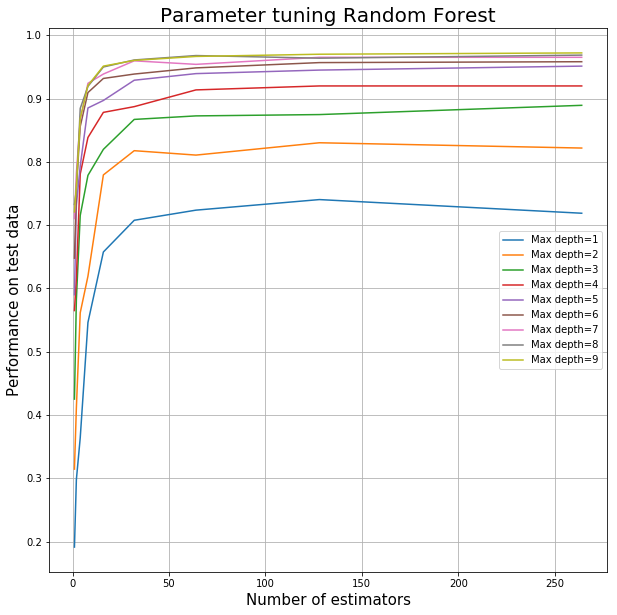

In [67]:
plt.figure(figsize=(10,10))
for i in np.unique(cv_results['param_max_depth']):
    to_plot = cv_results.loc[cv_results['param_max_depth'] == i,:]
    #plt.plot(to_plot['param_n_estimators'],to_plot['mean_train_score'], label='Max depth={}, training'.format(i))
    plt.plot(to_plot['param_n_estimators'],to_plot['mean_test_score'], label='Max depth={}'.format(i))
plt.grid()
plt.title('Parameter tuning Random Forest', size=20)
plt.ylabel('Performance on test data', size=15)
plt.xlabel('Number of estimators', size=15)
plt.legend(loc='right')

## More obvious example overfitting

In [68]:
clf = GradientBoostingClassifier()
grid = {'n_estimators':[2**i for i in range(10)],
       'max_depth':[4]}
clf_gs = GridSearchCV(estimator = clf, param_grid=grid, n_jobs=4)
clf_gs = clf_gs.fit(X=train[features], y=train['digit'])

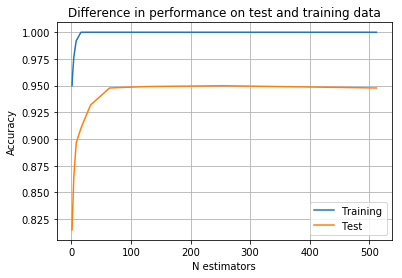

In [69]:
cv_results = pd.DataFrame(clf_gs.cv_results_)
plt.plot(cv_results['param_n_estimators'],cv_results['mean_train_score'], label='Training')
plt.plot(cv_results['param_n_estimators'],cv_results['mean_test_score'], label='Test')
plt.title('Difference in performance on test and training data')
plt.ylabel('Accuracy')
plt.xlabel('N estimators')
plt.legend(loc='lower right')
plt.grid()
#cv_results[['param_max_depth', 'mean_fit_time','mean_train_score','mean_test_score']]